#### These are the tasks you are asked to do:

For each user, determine her country based on the numeric IP address.

Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of different user experiences would you build based on the model output?

https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms

In [1]:
library(Hmisc, warn.conflict=FALSE)
library(dplyr, warn.conflict=FALSE)
library(rpart, warn.conflict=FALSE)
library(ggplot2, warn.conflict=FALSE)
library(ROCR, warn.conflict=FALSE)
library(randomForest, warn.conflict=FALSE)

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In [2]:
data <- read.csv(file="Fraud/Fraud_Data.csv")

In [3]:
ip_addresses <- read.csv(file="Fraud/IpAddress_to_Country.csv")

In [4]:
nrow(data) == length(unique(data$user_id))

[1] TRUE

In [5]:
head(data)

user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758369,0
333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311388,0
1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542444,0
221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0
159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2809315200,0


In [6]:
head(ip_addresses)

lower_bound_ip_address,upper_bound_ip_address,country
16777216,16777471,Australia
16777472,16777727,China
16777728,16778239,China
16778240,16779263,Australia
16779264,16781311,China
16781312,16785407,Japan


In [7]:
 data_country = rep(NA, nrow(data))
 for (i in 1: nrow(data)){
   tmp = as.character(ip_addresses[data$ip_address[i] >= ip_addresses$lower_bound_ip_address & data$ip_address[i] <= ip_addresses$upper_bound_ip_address,
                       "country"])
   if (length(tmp) == 1)  {
       data_country[i] = tmp
   }
 }

In [8]:
head(data_country)

[1] "Japan"         "United States" "United States" NA             
[5] "United States" "Canada"

In [9]:
data$country <- data_country

In [10]:
data[,"signup_time"] = as.POSIXct(data[,"signup_time"], tz="GMT")
data[, "purchase_time"] = as.POSIXct(data[,"purchase_time"],tz="GMT")

In [11]:
summary(as.factor(data$country))

United States                           China 
                          58049                           12038 
                          Japan                  United Kingdom 
                           7306                            4490 
              Korea Republic of                         Germany 
                           4162                            3646 
                         France                          Canada 
                           3161                            2975 
                         Brazil                           Italy 
                           2961                            1944 
                      Australia                     Netherlands 
                           1844                            1680 
             Russian Federation                           India 
                           1616                            1310 
Taiwan; Republic of China (ROC)                          Mexico 
                           1237                            1121 
                         Sweden                           Spain 
                           1090                            1027 
                   South Africa                     Switzerland 
                            838                             785 
                         Poland                       Argentina 
                            729                             661 
                      Indonesia                          Norway 
                            649                             609 
                       Colombia                          Turkey 
                            602                             568 
                       Viet Nam                         Romania 
                            550                             525 
                        Denmark                       Hong Kong 
                            490                             471 
                        Finland                         Austria 
                            460                             435 
                        Ukraine                           Chile 
                            429                             417 
                        Belgium      Iran (ISLAMIC Republic Of) 
                            409                             389 
                          Egypt                  Czech Republic 
                            359                             349 
                       Thailand                     New Zealand 
                            291                             278 
                         Israel                    Saudi Arabia 
                            272                             264 
                      Venezuela                         Ireland 
                            251                             240 
                 European Union                          Greece 
                            238                             231 
                       Portugal                         Hungary 
                            229                             211 
                       Malaysia                       Singapore 
                            210                             208 
                       Pakistan                     Philippines 
                            186                             177 
                       Bulgaria                         Morocco 
                            166                             158 
                        Algeria                            Peru 
                            122                             119 
                        Tunisia            United Arab Emirates 
                            118                             114 
                        Ecuador                       Lithuania 
                            106                              95 
                     Seychelles                           Kenya 
                             95                      

In [12]:
data$purchase_signup_diff <- as.numeric(difftime(as.POSIXct(data$purchase_time, tz="GMT"), as.POSIXct(data$signup_time, tz="GMT"), unit="secs"))

In [13]:
data <- data %>%
        group_by(device_id) %>%
        mutate(device_id_count = n())

In [14]:
data <- data.frame(data %>%
                    group_by(ip_address) %>%
                    mutate (ip_address_count = n())
                  )

In [15]:
data$signup_time_wd = format(data$signup_time, "%A")
data$purchase_time_wd = format(data$purchase_time, "%A")

In [16]:
data$signup_time_wy = as.numeric(format(data$signup_time, "%U"))
data$purchase_time_wy = as.numeric(format(data$purchase_time, "%U"))

In [17]:
data_rf <- data[, -c(1:3,5)]

In [18]:
head(data_rf)

purchase_value,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_id_count,ip_address_count,signup_time_wd,purchase_time_wd,signup_time_wy,purchase_time_wy
34,SEO,Chrome,M,39,732758369,0,Japan,4506682,1,1,Tuesday,Saturday,8,15
16,Ads,Chrome,F,53,350311388,0,United States,17944,1,1,Sunday,Monday,23,23
15,SEO,Opera,M,53,2621473820,1,United States,1,12,12,Thursday,Thursday,0,0
44,SEO,Safari,M,41,3840542444,0,NA,492085,1,1,Tuesday,Monday,17,18
39,Ads,Safari,M,45,415583117,0,United States,4361461,1,1,Tuesday,Wednesday,29,36
42,Ads,Chrome,M,18,2809315200,0,Canada,4240931,1,1,Thursday,Thursday,20,27


In [19]:
data_rf$country[is.na(data_rf$country)]="Not_found"
data_rf$country = ifelse(data_rf$country %in% names(sort(table(data_rf$country),decresing=TRUE))[51:length(unique(data_rf$country))],"other", as.character(data_rf$country)
                         )

In [20]:
data_rf$class<- as.factor(data_rf$class)

In [21]:
data_rf[sapply(data_rf,is.character)] <-lapply(data_rf[sapply(data_rf,is.character)], as.factor)

In [22]:
sapply(data_rf, class)

purchase_value               source              browser 
           "integer"             "factor"             "factor" 
                 sex                  age           ip_address 
            "factor"            "integer"            "numeric" 
               class              country purchase_signup_diff 
            "factor"             "factor"            "numeric" 
     device_id_count     ip_address_count       signup_time_wd 
           "integer"            "integer"             "factor" 
    purchase_time_wd       signup_time_wy     purchase_time_wy 
            "factor"            "numeric"            "numeric"

In [23]:
train_sample <- sample(nrow(data_rf), size=nrow(data) * 0.66)
train_data <- data_rf[train_sample,]
test_data<- data_rf[-train_sample,]

In [24]:
rf = randomForest(y=train_data$class, x=train_data[,-7],
                 ytest=test_data$class, xtest=test_data[,-7],
                 ntree=50, mtry=3, keep.forest = TRUE)
rf


Call:
 randomForest(x = train_data[, -7], y = train_data$class, xtest = test_data[,      -7], ytest = test_data$class, ntree = 50, mtry = 3, keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 3

        OOB estimate of  error rate: 4.39%
Confusion matrix:
      0    1 class.error
0 90285  102 0.001128481
1  4280 5066 0.457949925
                Test set error rate: 4.35%
Confusion matrix:
      0    1  class.error
0 46564   10 0.0002147121
1  2224 2581 0.4628511967

In [25]:
rf_cutoff = randomForest(y=train_data$class, x=train_data[,-7],
                 ytest=test_data$class, xtest=test_data[,-7],
                 ntree=50, mtry=3, cutoff=c(0.7,1-0.7),keep.forest = TRUE)
rf_cutoff


Call:
 randomForest(x = train_data[, -7], y = train_data$class, xtest = test_data[,      -7], ytest = test_data$class, ntree = 50, mtry = 3, cutoff = c(0.7,      1 - 0.7), keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 3

        OOB estimate of  error rate: 5.21%
Confusion matrix:
      0    1 class.error
0 89067 1320  0.01460387
1  3879 5467  0.41504387
                Test set error rate: 4.91%
Confusion matrix:
      0    1 class.error
0 46101  473  0.01015588
1  2049 2756  0.42643080

In [26]:
rf_results = data.frame (true_values = test_data$class,
                          predictions = rf$test$votes[,2]
                          )

In [27]:
pred = prediction (rf_results$predictions, rf_results$true_values)

numeric(0)

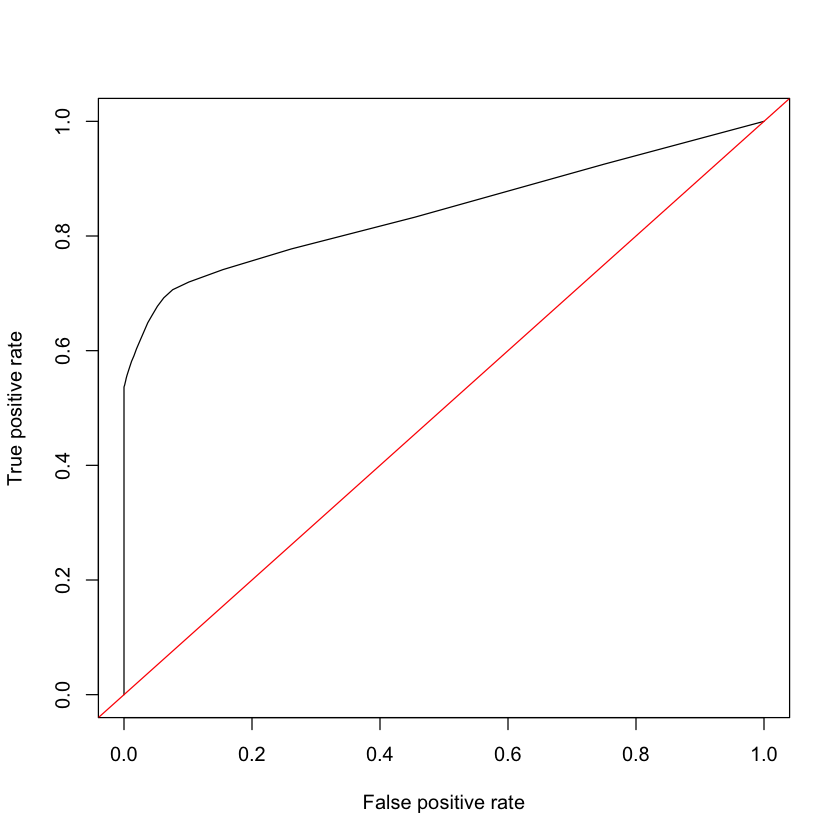

In [28]:
perf = performance (pred, measure = 'tpr', x.measure = "fpr")
 plot(perf) + abline(a=0, b=1, col = 'red') # the red line is randomness

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero (this was essentially the random forest output). However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up).

In [29]:
rf_results_cutoff = data.frame (true_values = test_data$class,
                          predictions = rf_cutoff$test$votes[,2]
                          )

In [30]:
pred_cutoff = prediction (rf_results_cutoff$predictions, rf_results_cutoff$true_values)

numeric(0)

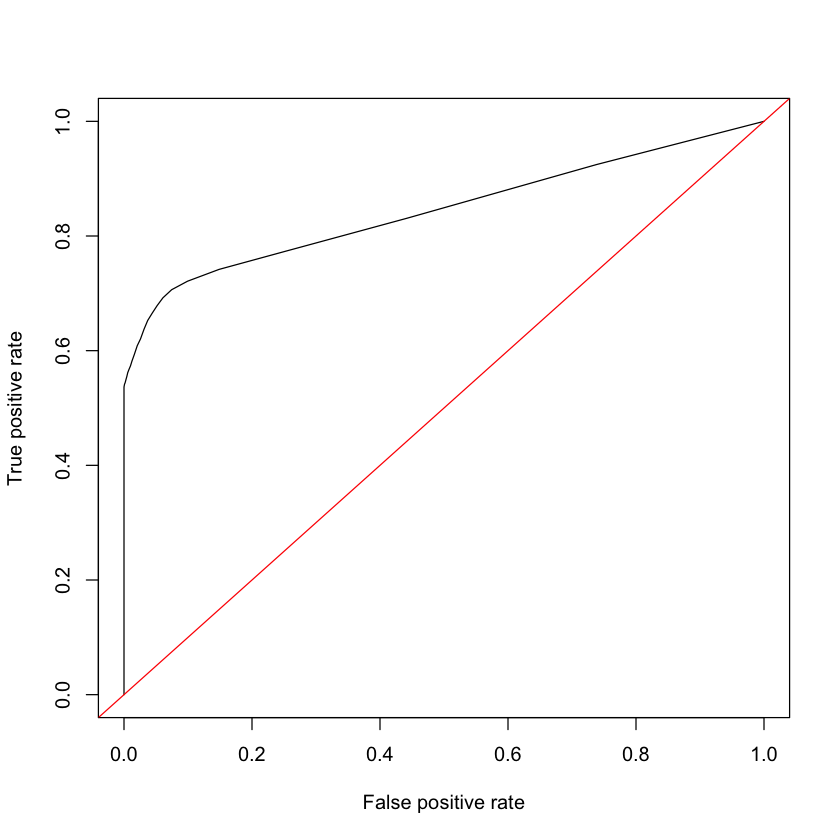

In [31]:
perf_cutoff = performance (pred_cutoff, measure = 'tpr', x.measure = "fpr")
 plot(perf_cutoff) + abline(a=0, b=1, col = 'red') # the red line is randomness

Regarding “how to use this from a product perspective”: you now have a model that assigns to each user a probability of committing a fraud. You want to think about creating different experiences based on that. For instance:
1. If predicted fraud probability < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted fraud probability < Z (so the user is at risk, but not too much), you can create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook.
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), you can tell the user his session has been put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud so the session is resumed.

In [ ]:
sort(importance(rf))
#newdata <- mtcars[order(mpg, cyl),]

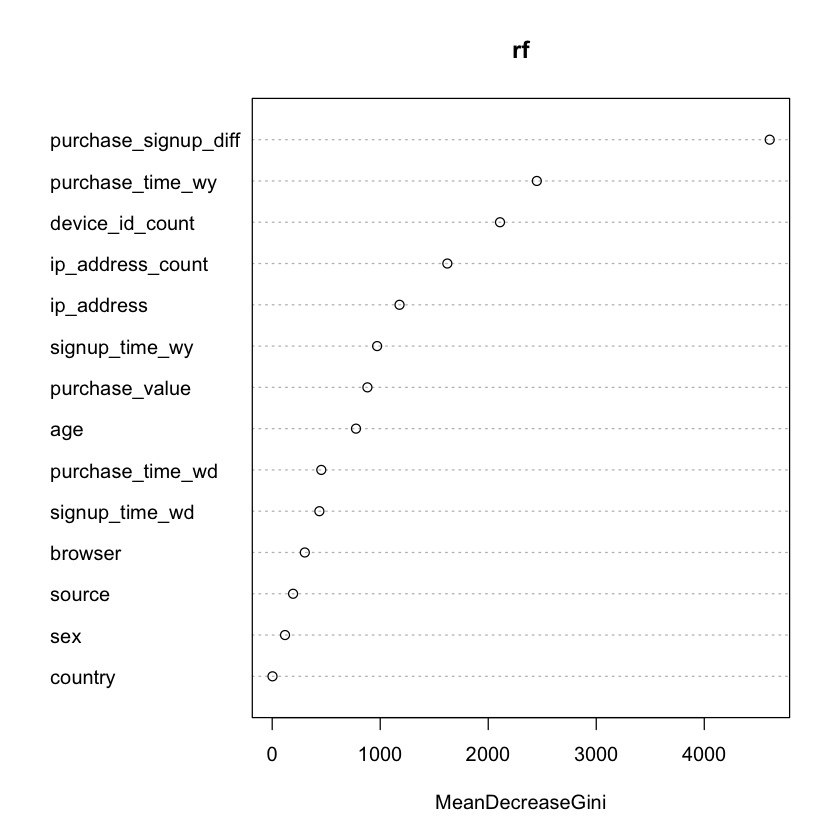

In [132]:
varImpPlot(rf,type=2)

In [ ]:
op <- par(mfrow=c(2, 2))
partialPlot(rf, train_data, country, 1)
partialPlot(rf, train_data, sex, 1)
partialPlot(rf, train_data, brower, 1)
partialPlot(rf, train_data, source, 1)
partialPlot(rf, train_data, signup_time_wd, 1)
partialPlot(rf, train_data, purchase_time_wd, 1)
partialPlot(rf, train_data, age, 1)